In [1]:
%matplotlib notebook

from pathlib import Path 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage as ndi

from skimage.color import label2rgb
from skimage.filters import sobel
from skimage import morphology
from skimage import measure
from skimage import feature
import skimage.filters as filt
import skimage.segmentation as seg

import ncempy.io as nio

from matplotlib.patches import Rectangle

## Load data

EMD file contains 1 data sets
Dataset #0 from detector: HAADF
pixel size = (5.4830, 5.4830) nm
{'pixelSizeUnit': ['nm', 'nm'], 'pixelSize': (5.483017815649768, 5.483017815649768), 'AcquisitionTime': datetime.datetime(2020, 11, 25, 16, 25, 38), 'Stage': {'Position': {'x': '-0.0001133663400000001', 'y': '-0.00049683710399999999', 'z': '-0.00011989836000000002'}, 'AlphaTilt': '-3.1359999999734965e-06', 'BetaTilt': '0.00055922558200545609', 'HolderType': 'FEI Double Tilt'}, 'detectorName': 'HAADF', 'dwellTime': '9.9999999999999995e-07'}


<IPython.core.display.Javascript object>


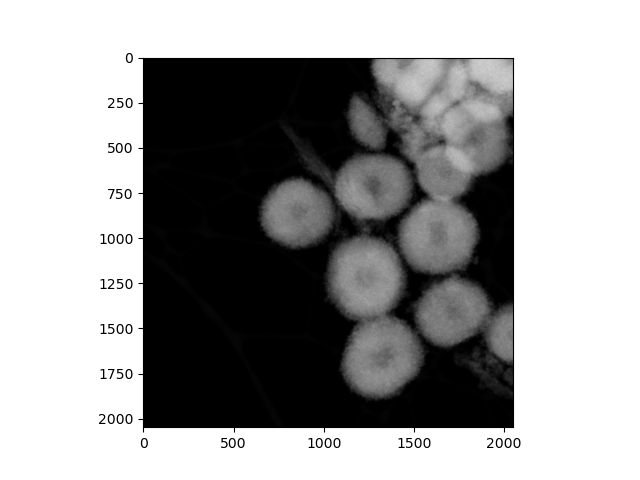

In [2]:
dPath = Path(r'C:\Users\alexl\Documents\Python\sphere-finder\data')
fPath = 'CaCO3_HAADF_1.emd'

emd1 = nio.emdVelox.fileEMDVelox(dPath / fPath)

print(emd1) #Print information about the file
im0, metadata0 = emd1.get_dataset(0)
print(metadata0)

fg, ax = plt.subplots(1,1)
ax.imshow(im0, cmap='gray')

## Region-based segmentation

<IPython.core.display.Javascript object>


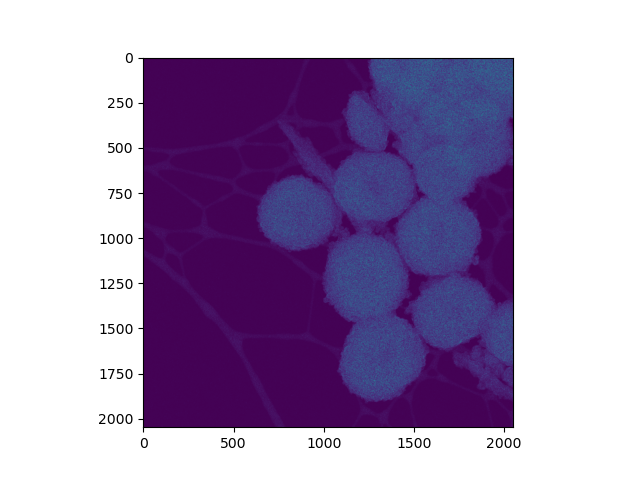

In [3]:
#Defining image data variable
im_data = im0

#Sobel gradient of image
elevation_map = sobel(im_data)
fg = plt.figure()
plt.imshow(elevation_map)

<IPython.core.display.Javascript object>


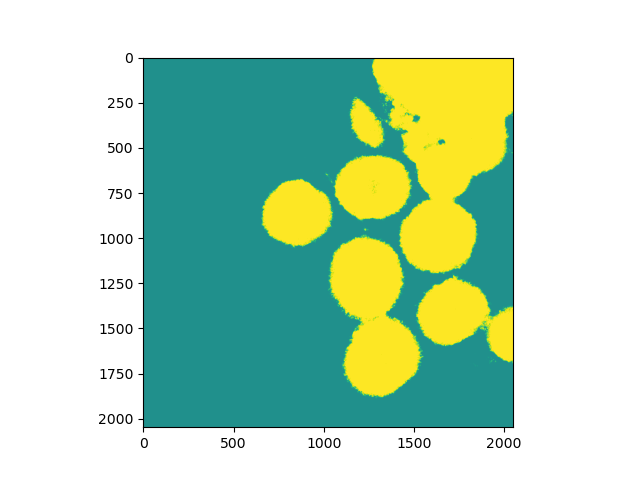

In [4]:
#Generate markers (regions from objects) based on threshold value based on Otsu's method
thresh_val = filt.threshold_otsu(im_data)

markers = np.zeros_like(im_data)
markers[im_data < thresh_val] = 1
markers[im_data > thresh_val] = 2


fg = plt.figure()
plt.imshow(markers)

<IPython.core.display.Javascript object>


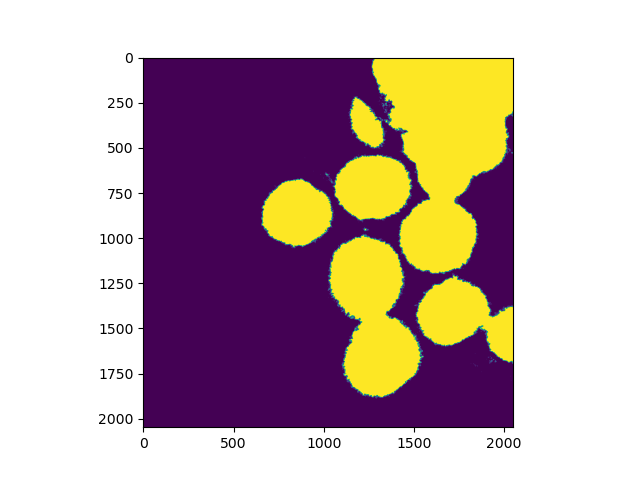

In [5]:
#Watershed transform to fill regions of the elevation map starting from the markers
segmentation_image = seg.watershed(elevation_map, markers)
segmentation_image = ndi.binary_fill_holes(segmentation_image - 1)
fg = plt.figure()
plt.imshow(segmentation_image)

## Clean data and and label spheres for quantification

<IPython.core.display.Javascript object>


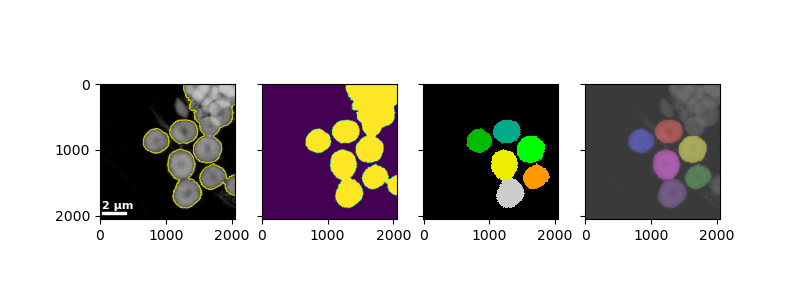

In [8]:
#Removing small particles and incomplete spheres
cleaned_image0 = morphology.remove_small_objects(segmentation_image, 35000)

#Removing objects touching image border
cleaned_image1 = seg.clear_border(cleaned_image0, buffer_size=5)

#Watershed segmentation to separate out particles that are touching and overlapping
distance = ndi.distance_transform_edt(cleaned_image0)
coords = feature.peak_local_max(distance, footprint=np.ones((50,50)), labels=cleaned_image0)
mask1 = np.zeros(distance.shape, dtype=bool)
mask1[tuple(coords.T)] = True
cleaned_image_markers, _ = ndi.label(mask1)
labels_ws = seg.watershed(-distance, cleaned_image_markers, mask=cleaned_image0)

#Clean data from the watershed segmentation
labels_ws0 = morphology.remove_small_objects(labels_ws, 35000)
labels_ws1 = seg.clear_border(labels_ws0, buffer_size=5)

#Show labeled spheres and overlay the labels onto original image data
labeled_spheres, number = ndi.label(labels_ws1)
image_label_overlay = label2rgb(labels_ws1, image=im_data, bg_label=0)

fg, axes = plt.subplots(1, 4, figsize=(8, 3), sharey=True)
axes[0].imshow(im_data, cmap=plt.cm.gray)
axes[0].contour(cleaned_image0, [0.5], linewidths=0.5, colors='y')
scaleL = (2000)/(metadata0['pixelSize'][0]) # scale bar length (nm)
scaleH = 30
scale_R = Rectangle((30,1950),scaleL,scaleH,color='w')
axes[0].add_patch(scale_R)
axes[0].text(30,1980-80,'2 \u03BCm',fontdict={'size':8,'weight':'bold','color':'w'})
axes[1].imshow(cleaned_image0)
axes[2].imshow(labels_ws1, cmap=plt.cm.nipy_spectral, interpolation='nearest')
axes[3].imshow(image_label_overlay)

## Quantify region properties

In [7]:
properties = measure.regionprops_table(labels_ws1, properties=('area',
                                                               'major_axis_length',
                                                               'minor_axis_length',
                                                               'eccentricity'))
df = pd.DataFrame(properties)
df['image_seq'] = '1'
print(df)

     area  major_axis_length  minor_axis_length  eccentricity image_seq
0  119134         424.173378         358.290832      0.535271         1
1  108605         386.028918         359.445770      0.364670         1
2  138041         430.744387         408.825654      0.314932         1
3  146485         460.514468         405.974979      0.472056         1
4  109828         404.577814         347.535204      0.511964         1
5  143564         450.988365         407.935065      0.426398         1
